In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI


from dotenv import load_dotenv

load_dotenv()

True

환경 변수 로드

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

상태 정의

In [4]:
tavily_search_tool = TavilySearchResults(
  max_results=1, 
  include_answer=True,
  include_raw_content=True,
  include_domains=["github.io", "wikidocs.net"]
)

tools = [tavily_search_tool]

사용할 도구 정의

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools)

LLM에 도구 바인딩

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition

def call_llm(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    return {"messages": [answer]}

tools = ToolNode(tools=[tavily_search_tool])

노드 정의

In [7]:
graph_builder = StateGraph(State)

graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("tools", tools)

기본적인 원리:

call_llm 노드가 tool_node에게 "웹 검색" 도구를 사용해 주세요.라고 알리면

tool_node는 "웹 검색" 도구를 사용해서 웹에서 검색 후 call_llm에게 다시 전달해준다.

In [8]:
graph_builder.add_conditional_edges(
    "call_llm",
    tools_condition,
)

조건부 엣지(Conditional Edges) 추가

조건부 엣지를 추가하면 call_llm이 도구를 사용할지 말지를 판단하게 된다.

In [9]:
graph_builder.add_edge("tools", "call_llm")
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", END)

그래프 간선 연결

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Multi-Turn 대화를 위한 `MemorySaver` 체크포인터 생성

In [11]:
graph = graph_builder.compile(checkpointer=memory)

그래프 컴파일

Multi-Turn 대화를 위해서 컴파일 시 `checkpointer`를 `MemorySaver`로 설정해준다.

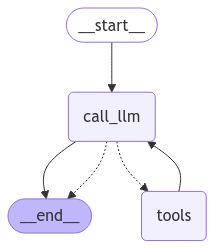

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

그래프 시각화

In [13]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1"})

`checkpointer`를 설정을 했으면 `RunnableConfig`를 사용해서 `thread_id`를 설정해줘야 한다.

Multi-Turn 대화 시 `thread_id`를 가지고 사용자를 구분하여 대화를 이어나갈 수 있다.

call_llm → tools → call_llm → tools ... (무한 루프)를 방지하기 위해서

`RunnableConfig`를 사용해서 `recursion_limit`값을 지정해 준다.

여기서는 최대 10개의 노드까지 방문하도록 설정.

START(1) → call_llm(2) → tools(3) → call_llm(4) → END(5)

In [14]:
question = ("안녕하세요. 스타듀밸리 게임에 대해서 검색해주세요.")
events = graph.stream({"messages": [("human", question)]}, config=config)

for event in events:
    for value in event.values():
        print(value["messages"][-1])

content='' additional_kwargs={'tool_calls': [{'id': 'call_1tI9gXV7GWKTPXoMIwtgfPmg', 'function': {'arguments': '{"query":"스타듀밸리 게임"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 94, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9008b94a-7d6c-400a-a84e-5d4f94bf4686-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '스타듀밸리 게임'}, 'id': 'call_1tI9gXV7GWKTPXoMIwtgfPmg', 'type': 'tool_call'}] usage_metadata={'input_tokens': 94, 'output_tokens': 25, 'total_tokens': 119, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

LLM에게 질문을 날려서 Tavily를 이용한 웹 검색을 하는지 확인

In [16]:
question = ("제가 방금 뭘 검색해달라고 했나요?")
events = graph.stream({"messages": [("human", question)]}, config=config)

for event in events:
    for value in event.values():
        print(value["messages"][-1].content)

당신은 "스타듀밸리 게임"에 대해 검색해 달라고 요청하셨습니다.


`MemorySaver` 체크포인터가 제대로 적용 되었는지, 이전 대화 내용 물어보기